In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm

sns.set(style="ticks", context='poster')
%matplotlib inline

RANDOM_SEED = 8927

In [3]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [2]:
pred_c = pd.read_excel('./raw_data/supp/Killing_correlation.xlsx')

In [4]:
x_MF = standardize(pred_c['MF'])

In [5]:
with pm.Model() as nb_reg_model:
    # A simple Bayesian negative binomial regression model
    β0 = pm.Normal("β0", 0., 2.5)
    β_MF = pm.Normal("β_MF", 0., 2.5)
    η = β0 + β_MF * x_MF
    α = pm.HalfNormal("α", 2.5)
    obs = pm.NegativeBinomial("obs", np.exp(η), α, observed=pred_c['Corpses'])

In [11]:
with nb_reg_model:
    trace = pm.sample(5000, tune=2000, random_seed=RANDOM_SEED, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β_MF, β0]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 12 seconds.


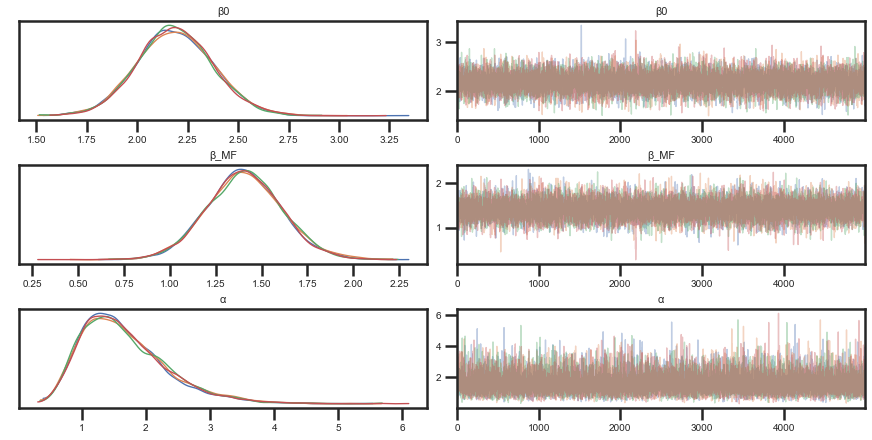

In [12]:
with nb_reg_model:
    az.plot_trace(trace)

In [13]:
with nb_reg_model:
    display(az.summary(trace, round_to=2, hdi_prob=0.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,2.19,0.19,1.81,2.56,0.00,0.0,15684.50,15684.50,15745.07,14196.19,1.0
β_MF,1.41,0.21,1.00,1.82,0.00,0.0,17701.85,17640.00,17907.54,13900.66,1.0
α,1.66,0.68,0.55,3.01,0.01,0.0,13969.35,11653.53,16382.23,10494.16,1.0


In [14]:
with nb_reg_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["β0", "β_MF", "obs"])

/opt/anaconda3/envs/python37/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0.5, 1.0, '$\\mathrm{log}(y) = \\beta_0 + \\beta_1 x$')

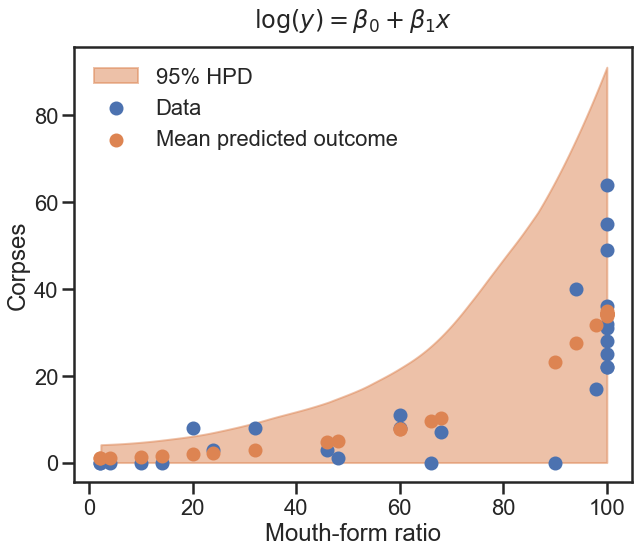

In [15]:
_, ax = plt.subplots(figsize=(10,8))
az.plot_hpd(pred_c['MF'], ppc["obs"], ax=ax, fill_kwargs={"alpha": 0.5, "label": "95% HPD"},
hdi_prob=0.95)
plt.scatter(pred_c['MF'], pred_c['Corpses'], label='Data')
plt.scatter(pred_c['MF'], np.mean(ppc["obs"].T, axis=1), label='Mean predicted outcome')
plt.legend(frameon=False)
ax.set_xlabel(r"Mouth-form ratio")
ax.set_ylabel("Corpses")
ax.set_title(r"$\mathrm{log}(y) = \beta_0 + \beta_1 x$", pad=20)